In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

### Preamble : Manifolds

A manifold is set of points, along with of neighbourhoods for each point (topological space) that locally resembles Euclidean space near each point. Specifically, each point of an $n$-dimensional manifold ($n$-manifold) has a neighborhood that is continous (homeomorphic) to the Euclidean space of dimension $n$.

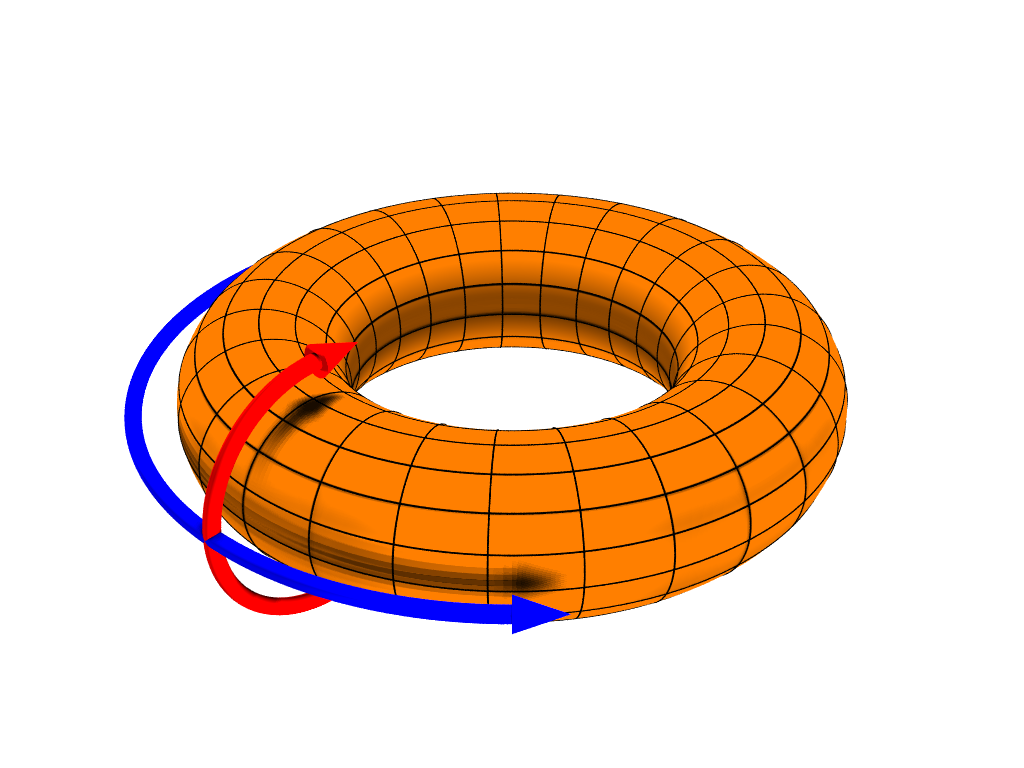

# Manifold learning 

Manifold learning is an approach to non-linear dimensionality reduction (NLDR). Where we assume that the data of interest lie on an embedded non-linear manifold within the higher-dimensional space.

## Introduction

Non-linear methods for dimensionality reduction (compared to linear methods SVD, PCA, ICA, FA) can be broadly classified into two groups:
1. Those that provide a mapping (either from the high-dimensional space to the low-dimensional embedding or vice versa) [These may be viewed as a preliminary feature extraction step before we can train a classifier]
2. Those that just give a visualisation [These are based on proximity data, i.e. distance measurements]

The reduced-dimensional representations of data are often referred to as "intrinsic variables". This description implies that these are the values from which the data was produced. For example, consider a dataset that contains images of a letter 'A', which has been scaled and rotated by varying amounts. Each image has $32\times32$ pixels. Each image can be represented as a vector of 1024 pixel values. Each row is a sample on a two-dimensional manifold in $1024$-dimensional space (a Hamming space). The intrinsic dimensionality is two, because two variables (rotation and scale) were varied in order to produce the data. Information about the shape or look of a letter 'A' is not part of the intrinsic variables because it is the same in every instance. Nonlinear dimensionality reduction will discard the correlated information (the letter 'A') and recover only the varying information (rotation and scale). The image to the right shows sample images from this dataset (to save space, not all input images are shown), and a plot of the two-dimensional points that results from using a NLDR algorithm (in this case, Manifold Sculpting was used) to reduce the data into just two dimensions.

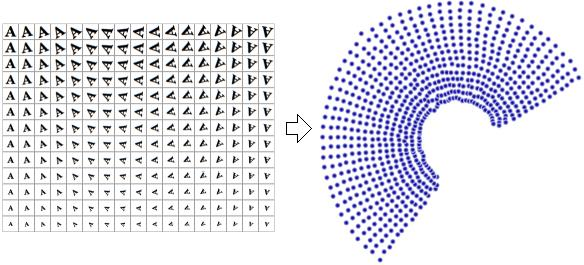

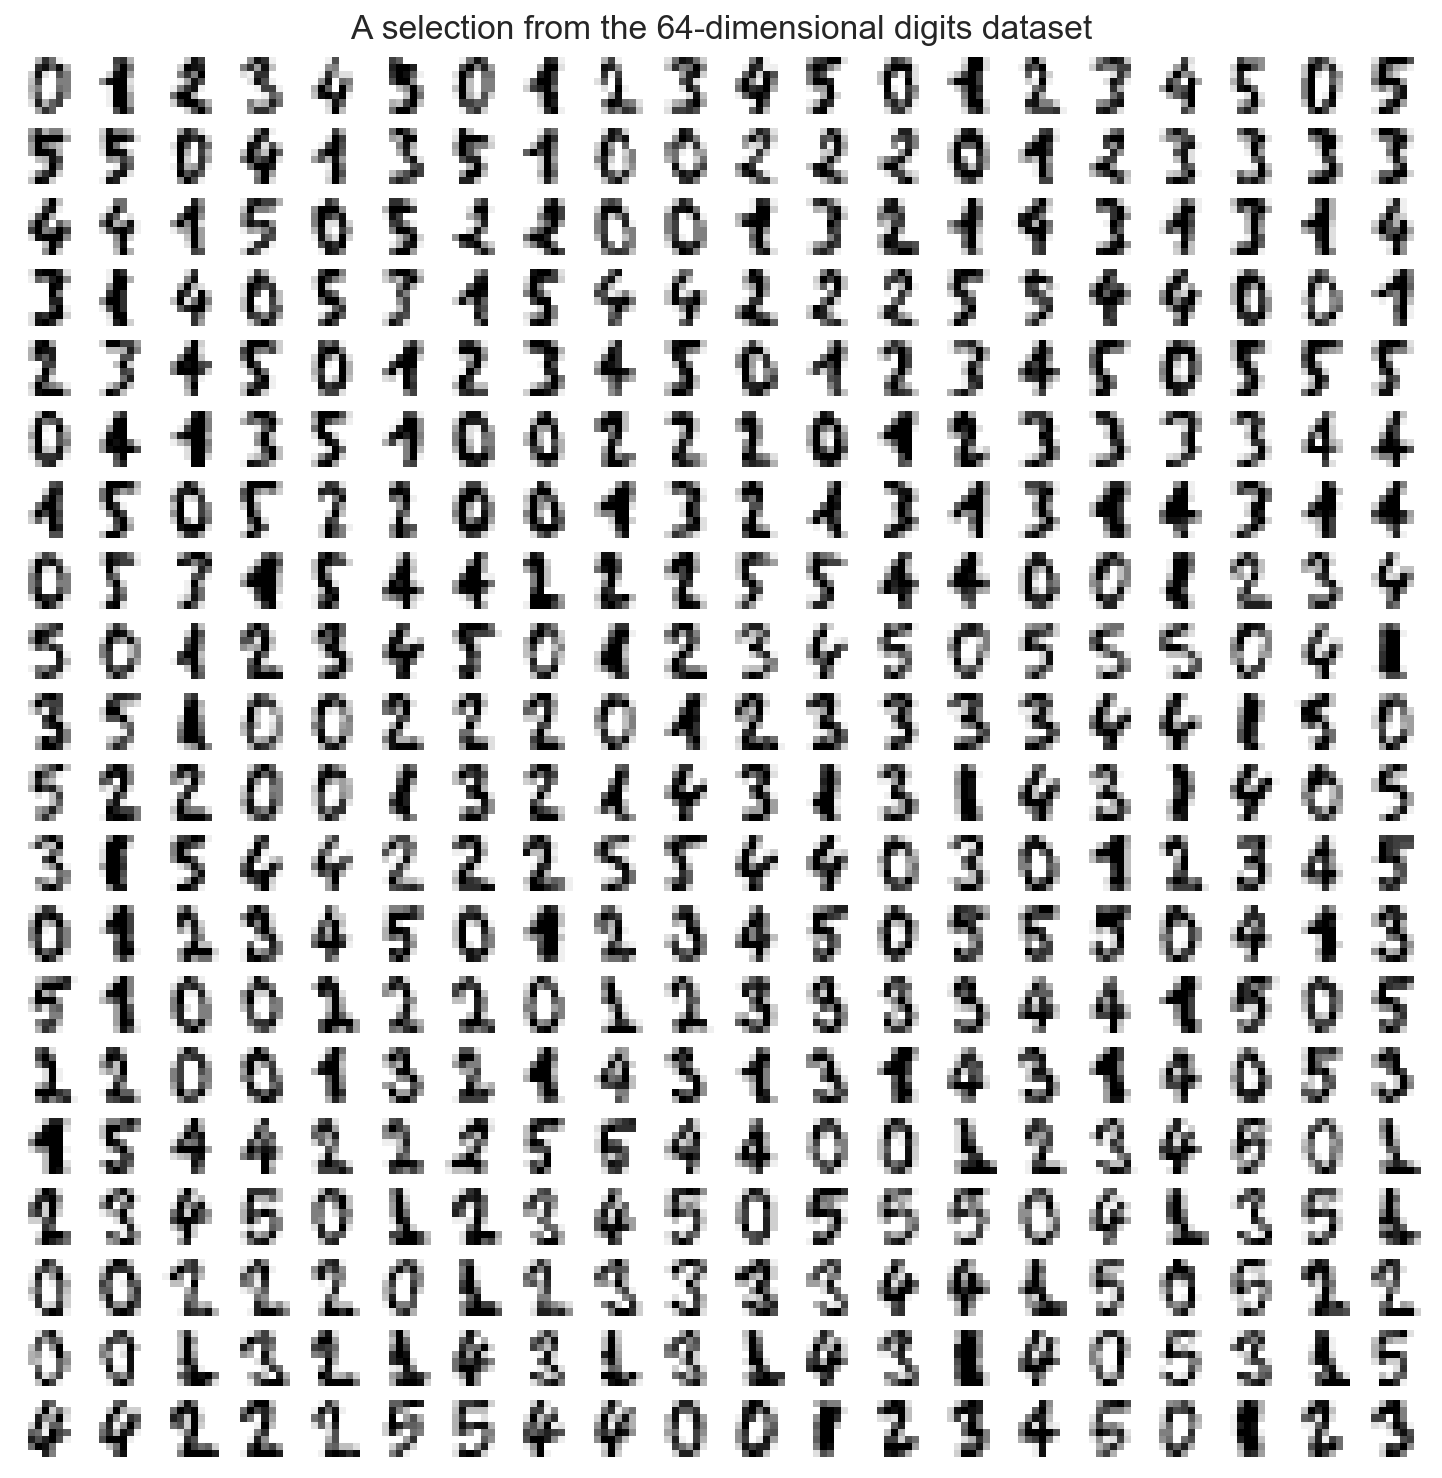

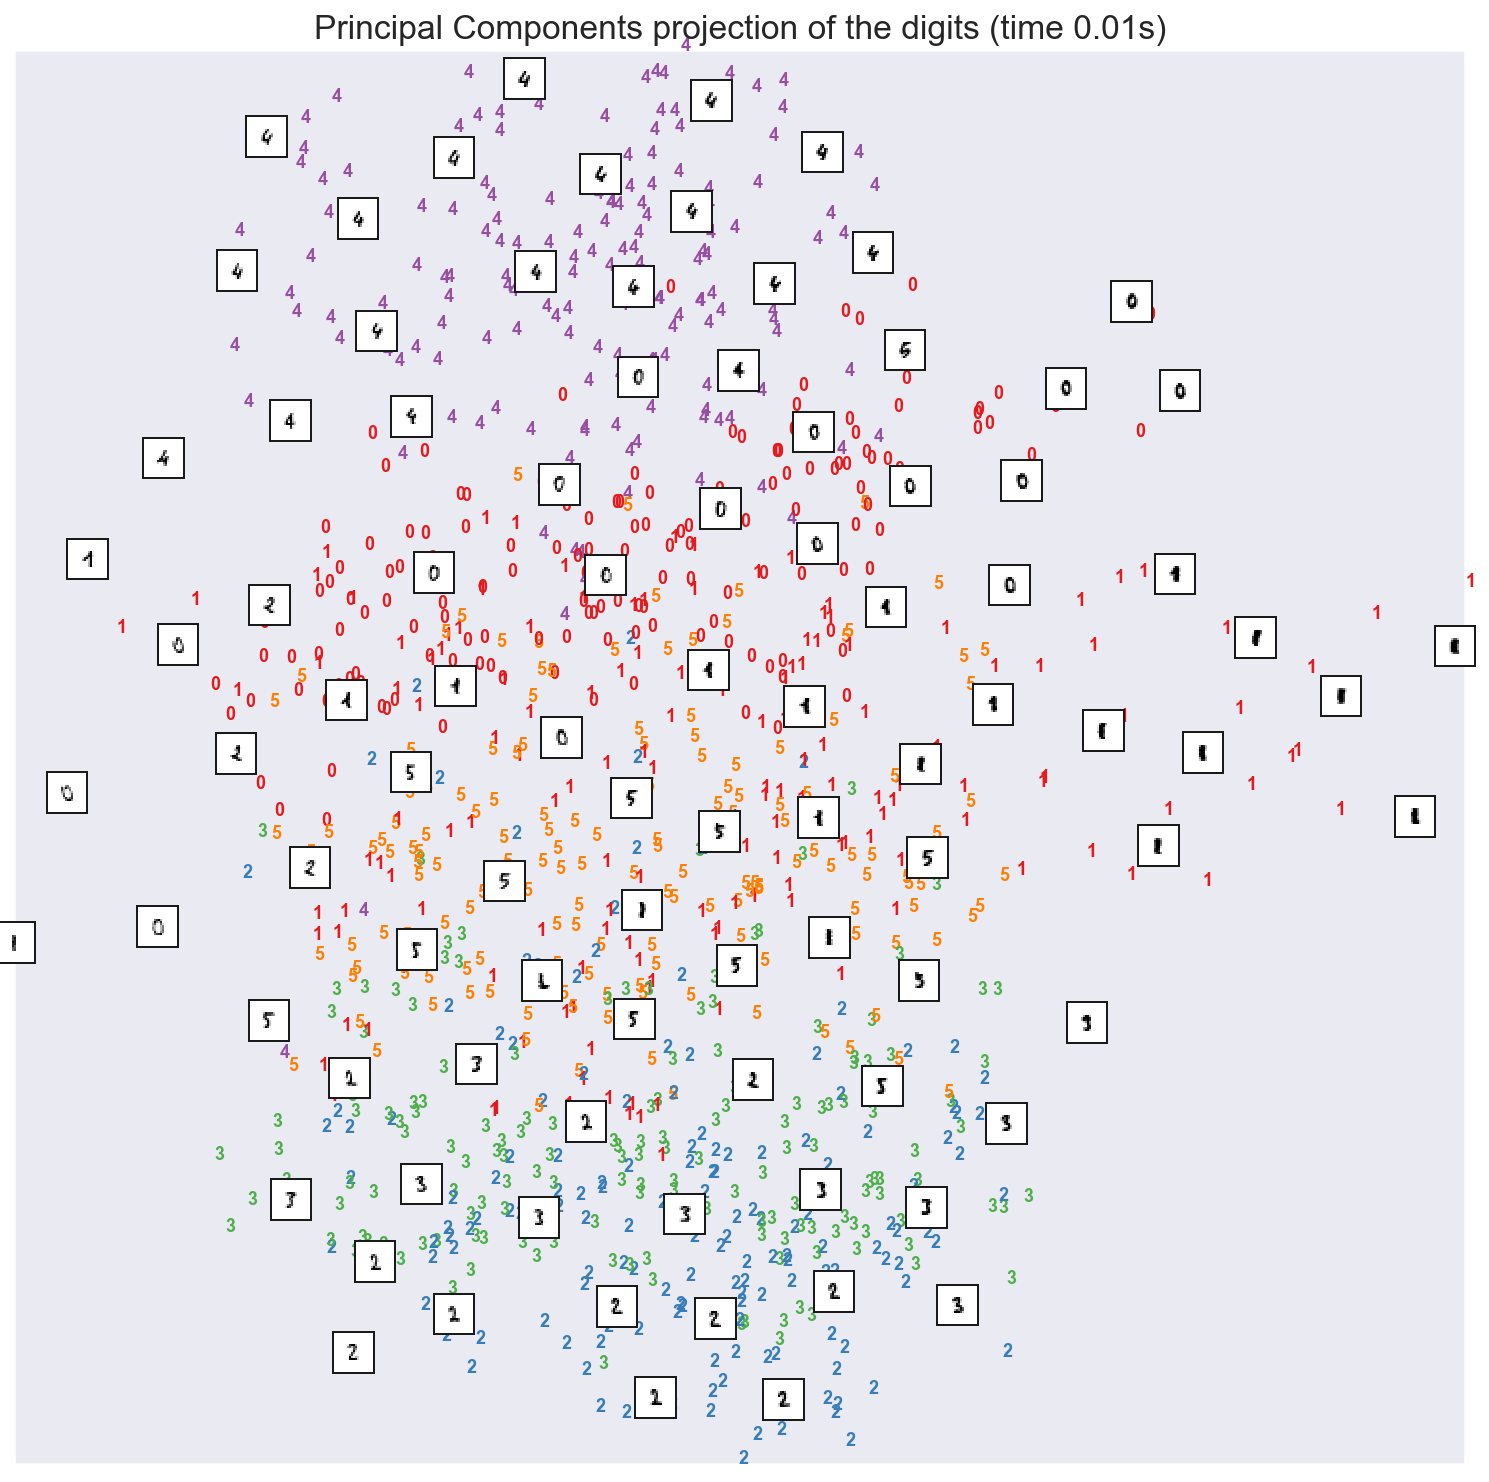

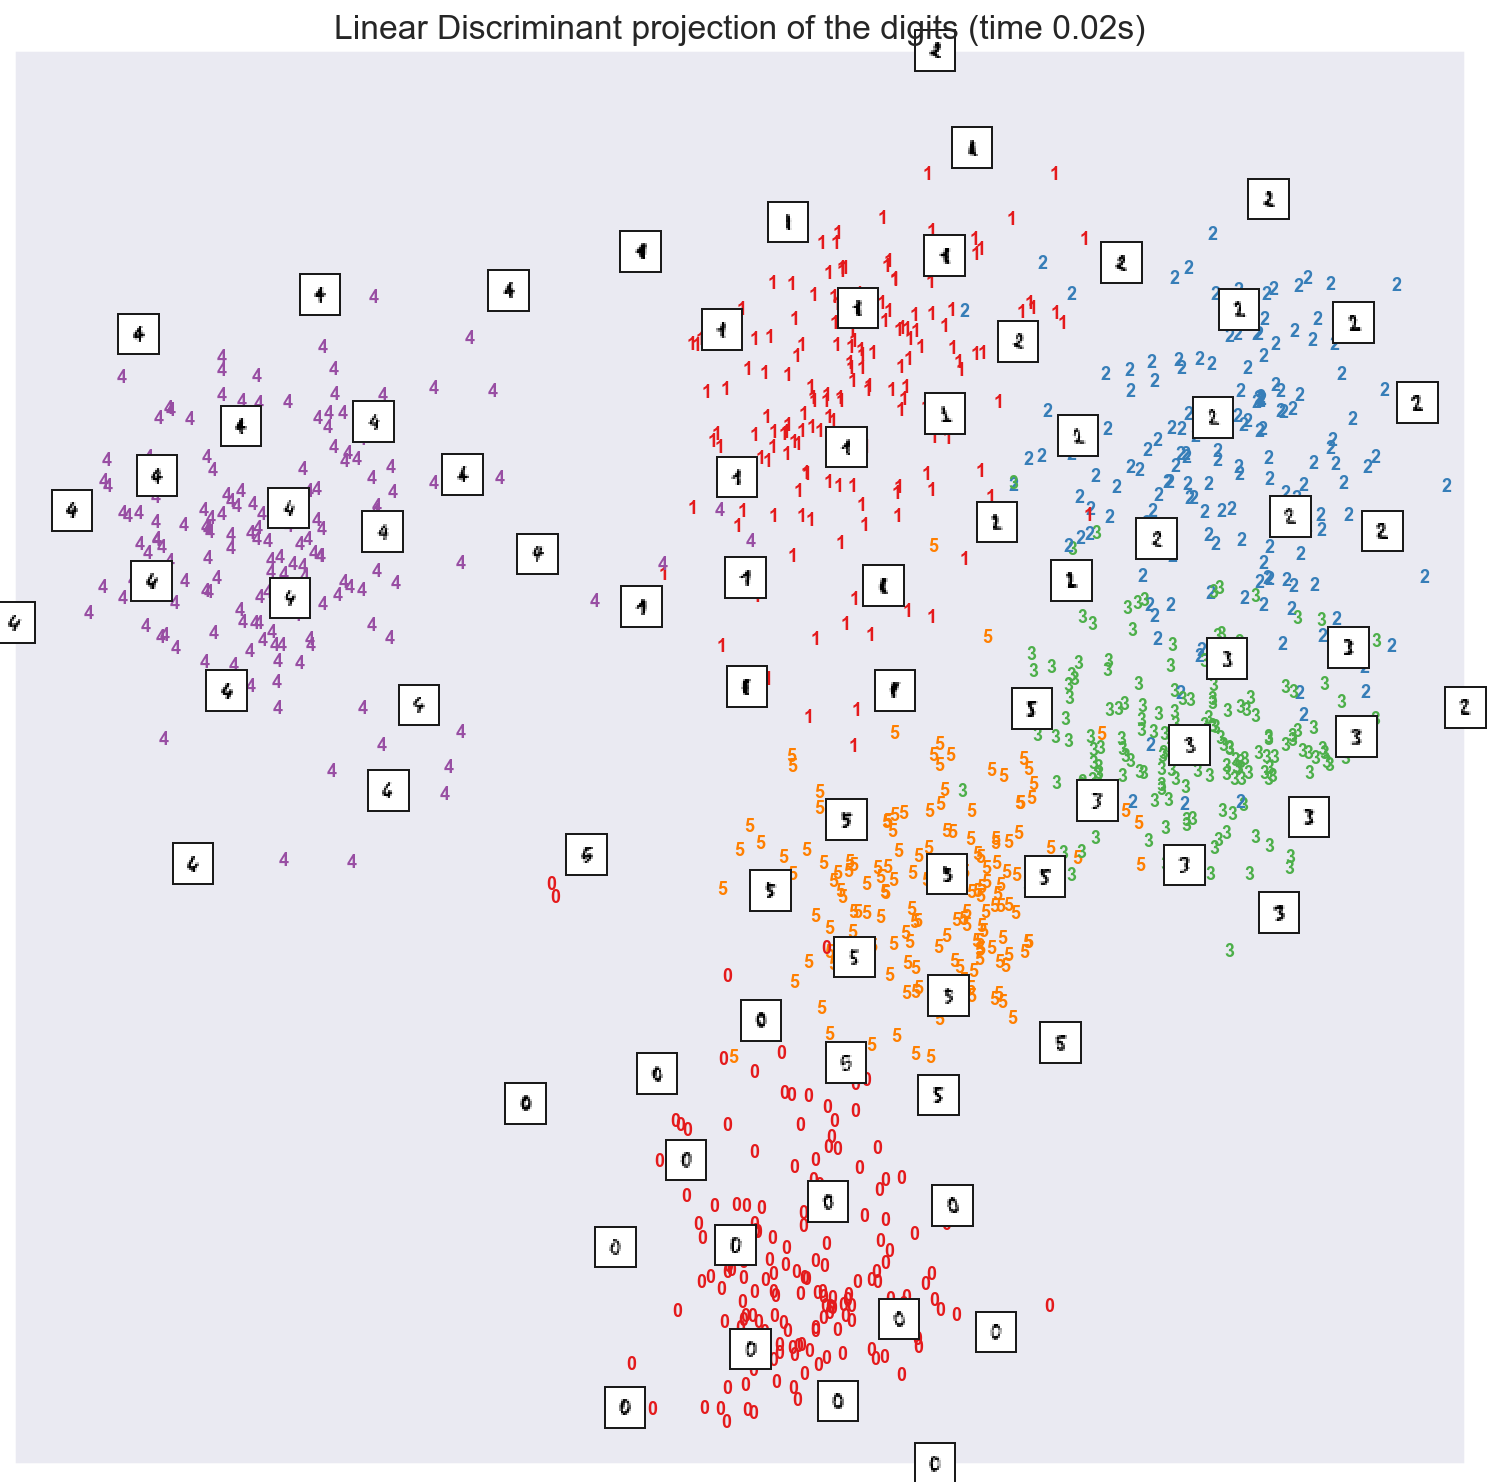

In [2]:
from time import time
from matplotlib import offsetbox
from sklearn import (datasets, decomposition, discriminant_analysis)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors


def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(13,13))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


# ----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

        
plt.figure(figsize=(13,13))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

## Isomap

One of the earliest approaches to manifold learning is the Isomap, which  is a combination of the *Floyd–Warshall* (Shortest-path graph search) algorithm with classic Multidimensional Scaling (MDS). Classic MDS takes a matrix of pair-wise distances between all points and computes a position for each point. Isomap assumes that the pair-wise distances are only known between neighboring points, and uses the *Floyd–Warshall* algorithm to compute the pair-wise distances between all other points. This effectively estimates the full matrix of pair-wise geodesic distances (where geodesic distance is measured as the number of edges between the shortest path connecting two verticies) between all of the points. Isomap then uses classic MDS to compute the reduced-dimensional positions of all the points.

#### Complexity

The Isomap algorithm comprises three stages:

1.  **Nearest neighbor search.** Isomap uses
    `sklearn.neighbors.BallTree` for
    efficient neighbor search. The cost is approximately
    $O[D \log(k) N \log(N)]$, for $k$ nearest neighbors of $N$ points in
    $D$ dimensions.
2.  **Shortest-path graph search.** The most efficient known algorithms
    for this are *Dijkstra\'s Algorithm*, which is approximately
    $O[N^2(k + \log(N))]$, or the *Floyd-Warshall algorithm*, which is
    $O[N^3]$. The algorithm can be selected by the user with the
    `path_method` keyword of `Isomap`. If unspecified, the code attempts
    to choose the best algorithm for the input data.
3.  **Partial eigenvalue decomposition.** The embedding is encoded in
    the eigenvectors corresponding to the $d$ largest eigenvalues of the
    $N \times N$ isomap kernel. For a dense solver, the cost is
    approximately $O[d N^2]$. This cost can often be improved using the
    `ARPACK` solver. The eigensolver can be specified by the user with
    the `path_method` keyword of `Isomap`. If unspecified, the code
    attempts to choose the best algorithm for the input data.

The overall complexity of Isomap is
$O[D \log(k) N \log(N)] + O[N^2(k + \log(N))] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

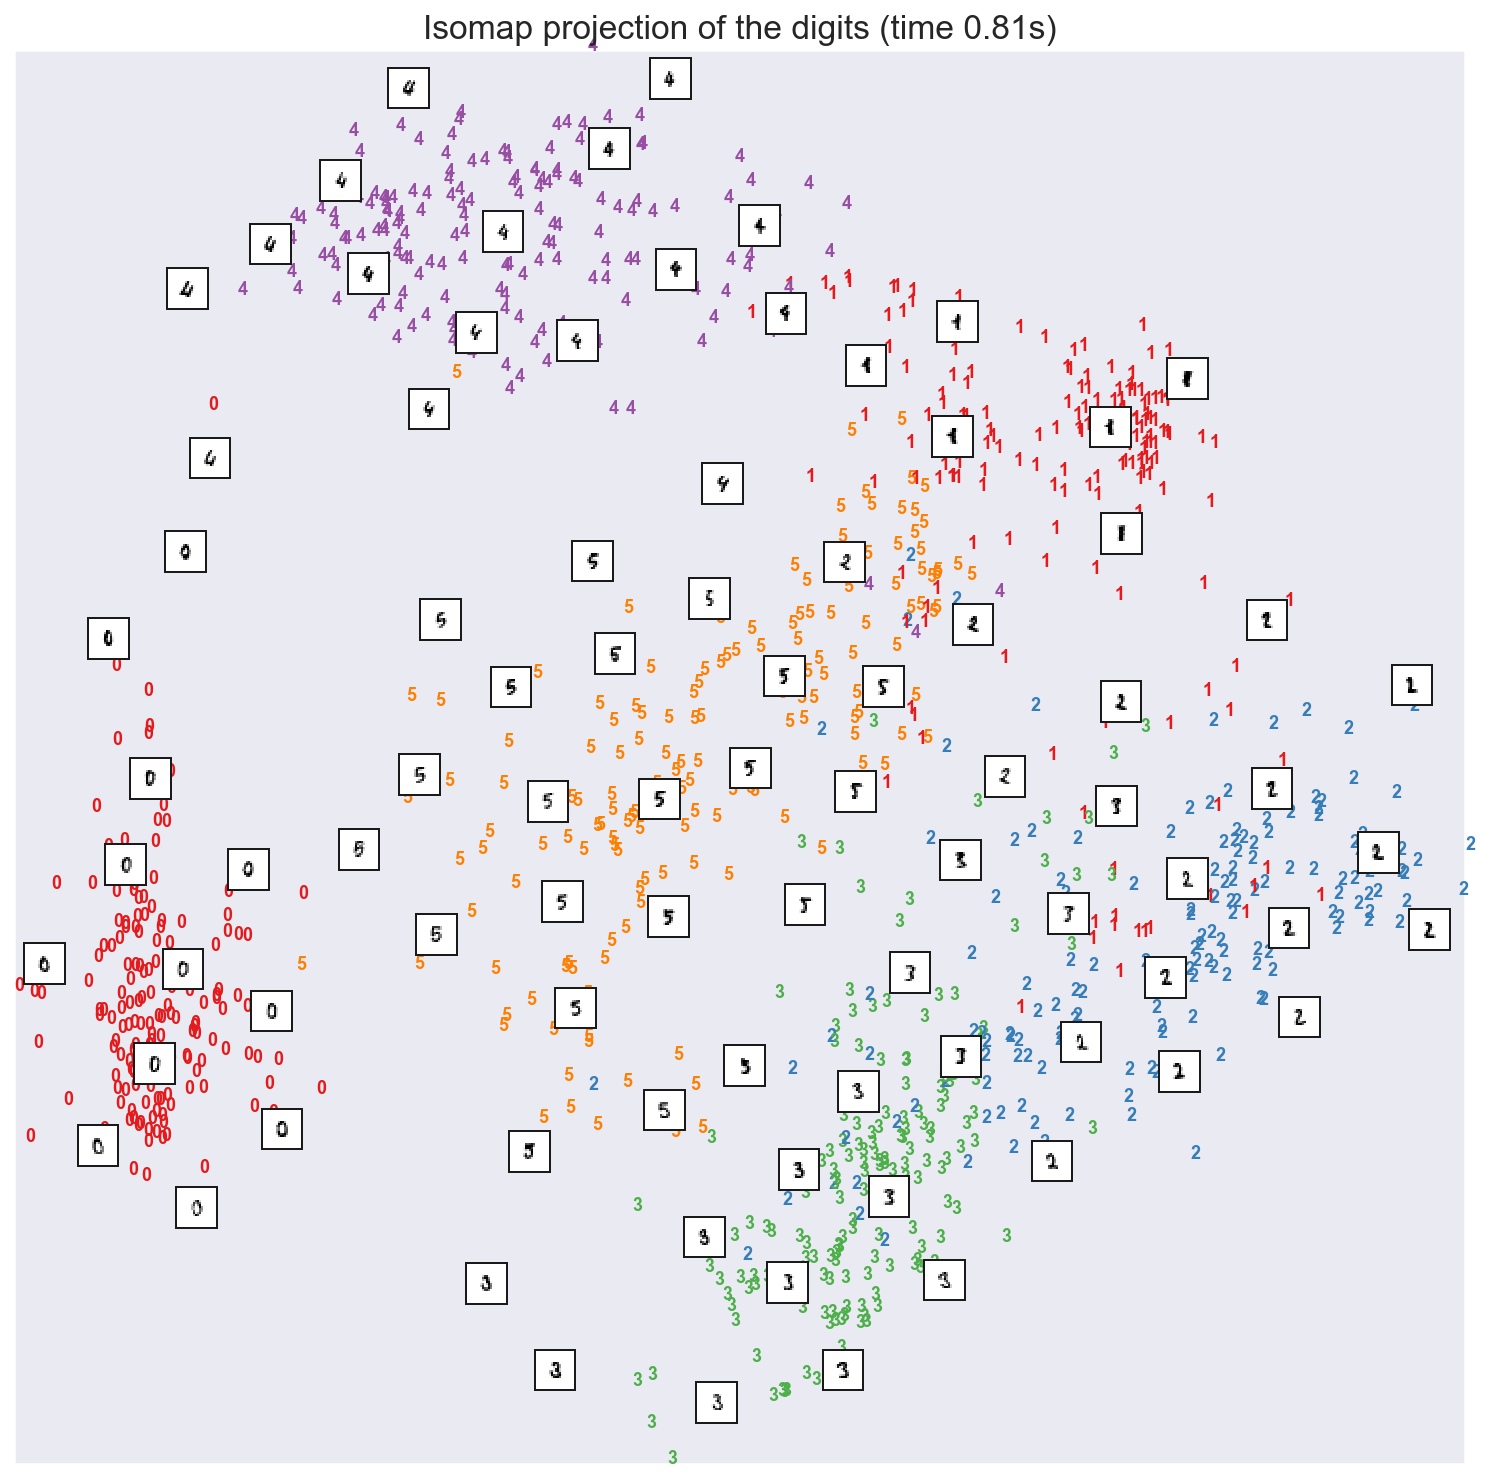

In [3]:
from sklearn.manifold import Isomap

t0 = time()
X_iso = Isomap(n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))
plt.show()

## Locally-linear embedding


Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It was presented at approximately the same time as Isomap. It has several advantages over Isomap, including faster optimization when implemented to take advantage of sparse matrix algorithms, and better results with many problems. LLE also begins by finding a set of the nearest neighbors of each point. It then computes a set of weights for each point that best describes the point as a linear combination of its neighbors. Finally, it uses an eigenvector-based optimization technique to find the low-dimensional embedding of points, such that each point is still described with the same linear combination of its neighbors. LLE tends to handle non-uniform sample densities poorly because there is no fixed unit to prevent the weights from drifting as various regions differ in sample densities. LLE has no internal model.


#### Complexity

The standard LLE algorithm comprises three stages:

1.  **Nearest Neighbors Search**. See discussion under Isomap above.
2.  **Weight Matrix Construction**. $O[D N k^3]$. The construction of
    the LLE weight matrix involves the solution of a $k \times k$ linear
    equation for each of the $N$ local neighborhoods
3.  **Partial Eigenvalue Decomposition**. See discussion under Isomap
    above.

The overall complexity of standard LLE is
$O[D \log(k) N \log(N)] + O[D N k^3] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

Reconstruction error: 1.63545e-06


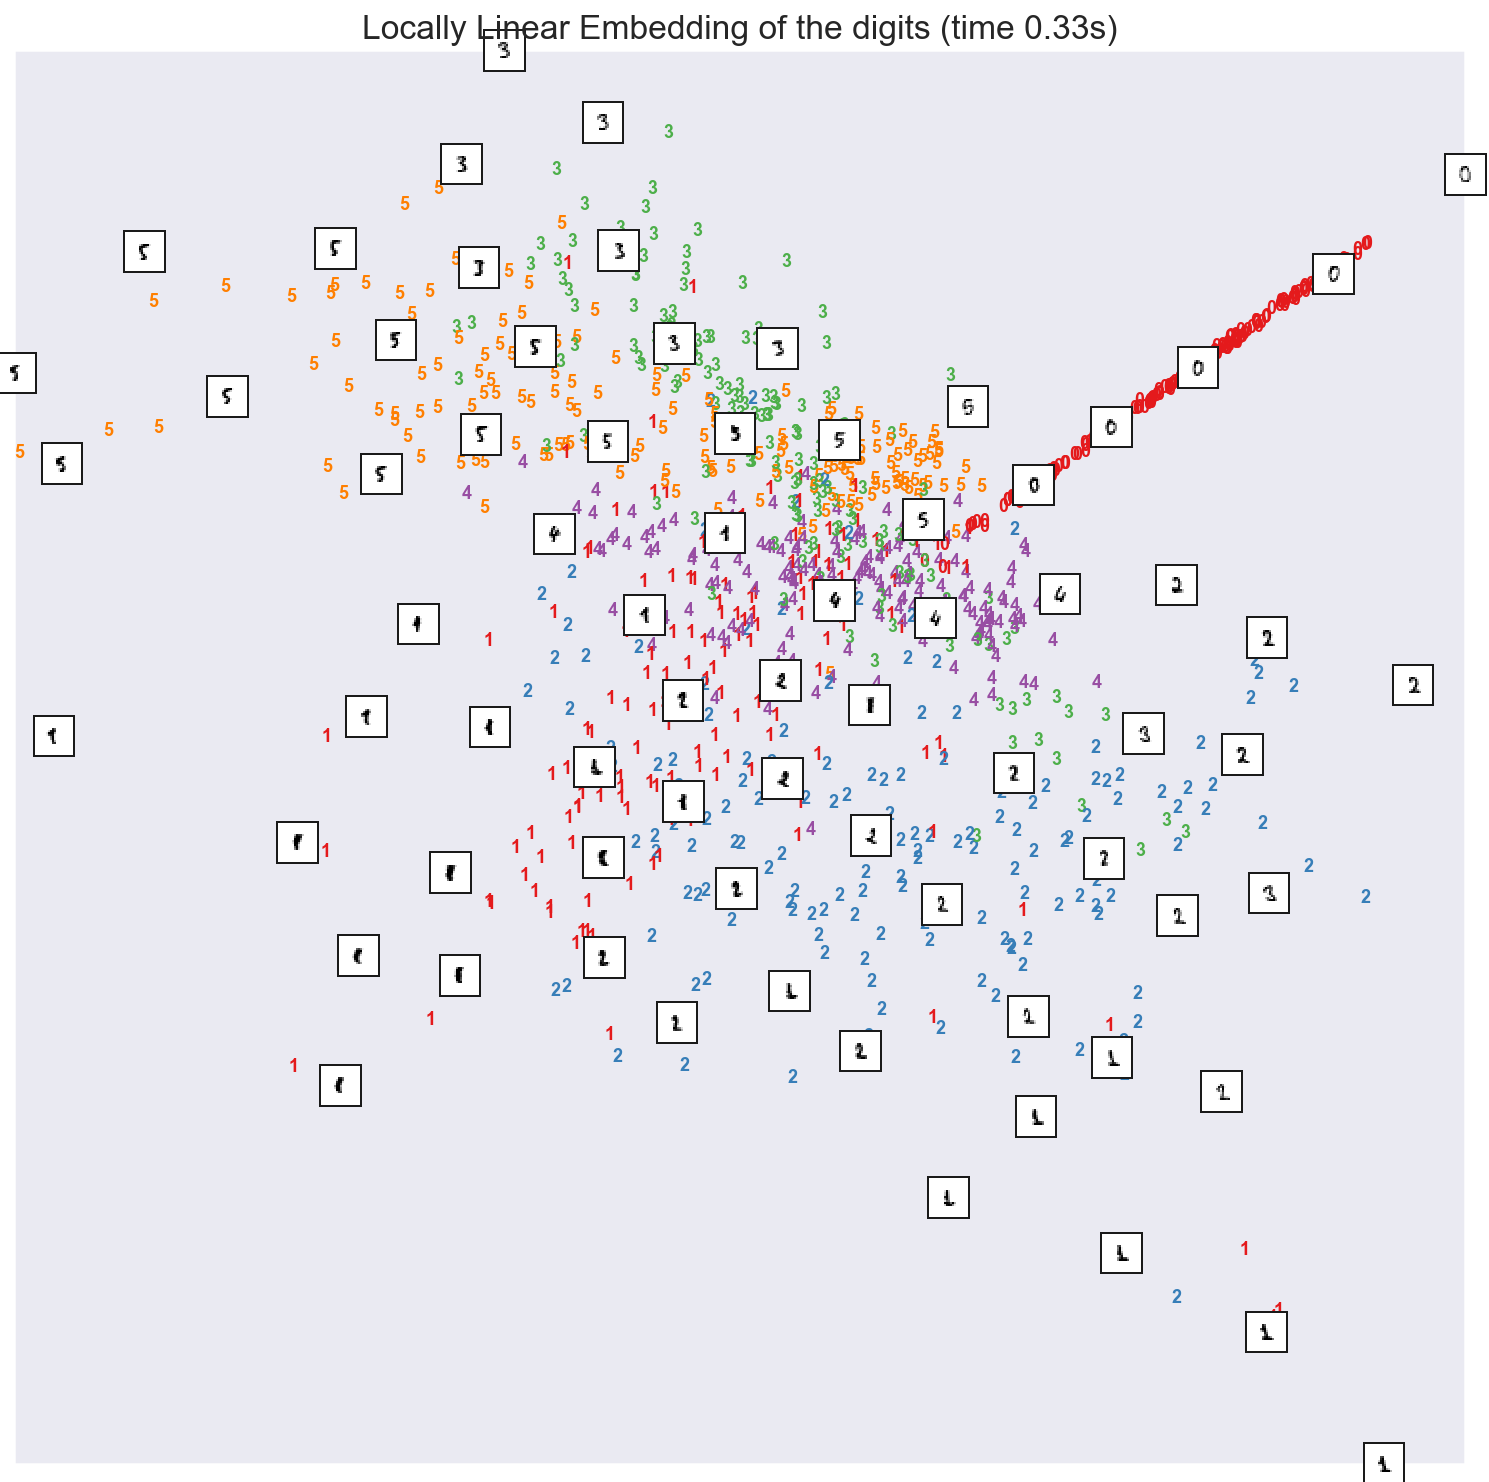

In [4]:
from sklearn.manifold import LocallyLinearEmbedding

clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

## Modified Locally-Linear Embedding (MLLE)

Modified LLE (MLLE) is another LLE variant which uses multiple weights in each neighborhood to address the local weight matrix conditioning problem which leads to distortions in LLE maps. MLLE produces robust projections, but without the significant additional computational cost.

This was motivated as one well-known issue with LLE is the regularization problem. When the
number of neighbors is greater than the number of input dimensions, the
matrix defining each local neighborhood is rank-deficient. To address
this, standard LLE applies an arbitrary regularization parameter $r$,
which is chosen relative to the trace of the local weight matrix. Though
it can be shown formally that as $r \to 0$, the solution converges to
the desired embedding, there is no guarantee that the optimal solution
will be found for $r > 0$. This problem manifests itself in embeddings
which distort the underlying geometry of the manifold.

MLLE can be performed with function
`locally_linear_embedding` or its
object-oriented counterpart `LocallyLinearEmbedding`, with the keyword `method = 'modified'`. It requires
`n_neighbors > n_components`.

#### Complexity

The MLLE algorithm comprises three stages:

1.  **Nearest Neighbors Search**. Same as standard LLE
2.  **Weight Matrix Construction**. Approximately
    $O[D N k^3] + O[N (k-D) k^2]$. The first term is exactly equivalent
    to that of standard LLE. The second term has to do with constructing
    the weight matrix from multiple weights. In practice, the added cost
    of constructing the MLLE weight matrix is relatively small compared
    to the cost of stages 1 and 3.
3.  **Partial Eigenvalue Decomposition**. Same as standard LLE

The overall complexity of MLLE is
$O[D \log(k) N \log(N)] + O[D N k^3] + O[N (k-D) k^2] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

Reconstruction error: 0.360652


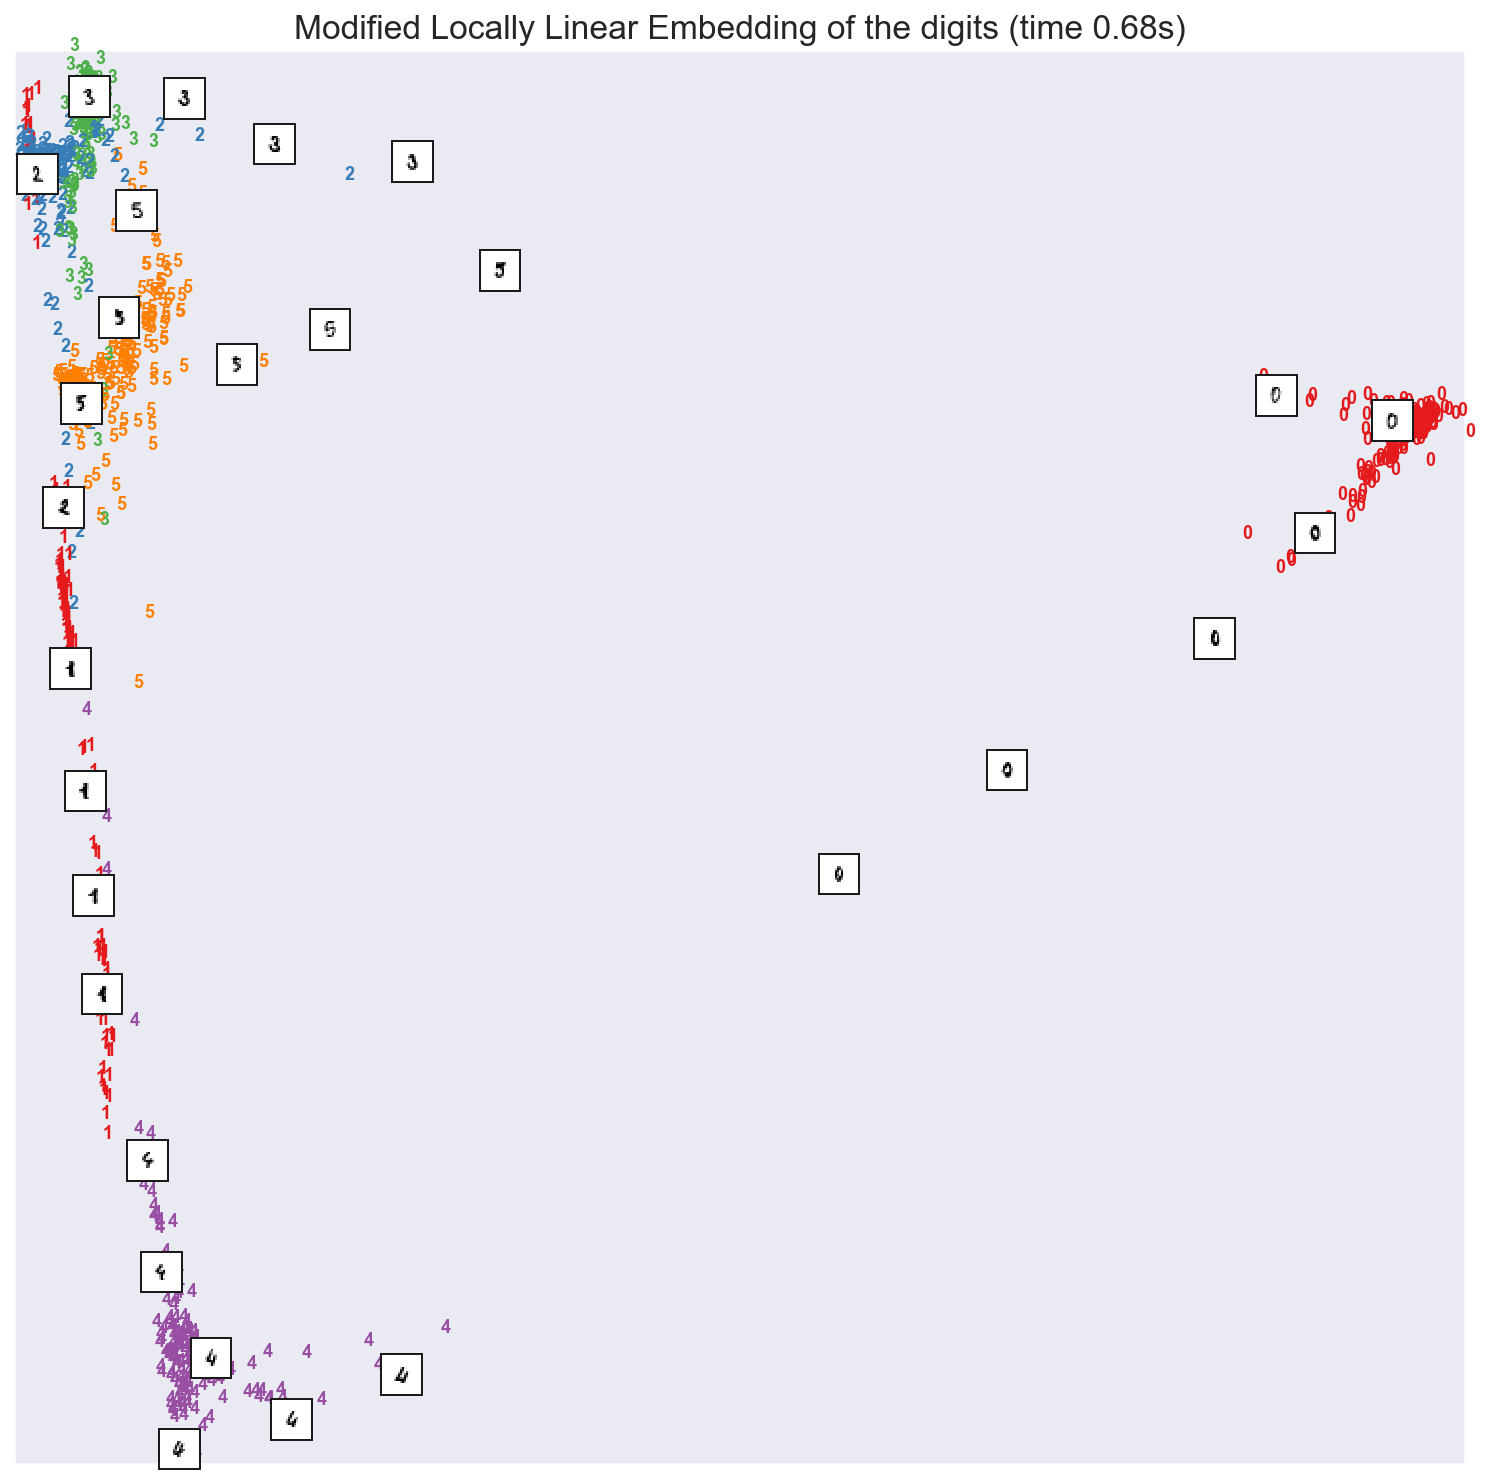

In [5]:
from sklearn.manifold import LocallyLinearEmbedding
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

## Hessian Locally-Linear Embedding (Hessian LLE)

Like LLE, Hessian LLE is also based on sparse matrix techniques. It tends to yield results of a much higher quality than LLE. Unfortunately, it has a very costly computational complexity, so it is not well-suited for heavily sampled manifolds. It has no internal model.

It revolves around
a hessian-based quadratic form at each neighborhood which is used to
recover the locally linear structure. Though other implementations note
its poor scaling with data size, `sklearn` implements some algorithmic
improvements which make its cost comparable to that of other LLE
variants for small output dimension. HLLE can be performed with function
`locally_linear_embedding` or its
object-oriented counterpart `LocallyLinearEmbedding`
role="class"}, with the keyword `method = 'hessian'`. It requires
`n_neighbors > n_components * (n_components + 3) / 2`.

#### Complexity

The HLLE algorithm comprises three stages:

1.  **Nearest Neighbors Search**. Same as standard LLE
2.  **Weight Matrix Construction**. Approximately
    $O[D N k^3] + O[N d^6]$. The first term reflects a similar cost to
    that of standard LLE. The second term comes from a QR decomposition
    of the local hessian estimator.
3.  **Partial Eigenvalue Decomposition**. Same as standard LLE

The overall complexity of standard HLLE is
$O[D \log(k) N \log(N)] + O[D N k^3] + O[N d^6] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

Reconstruction error: 0.212806


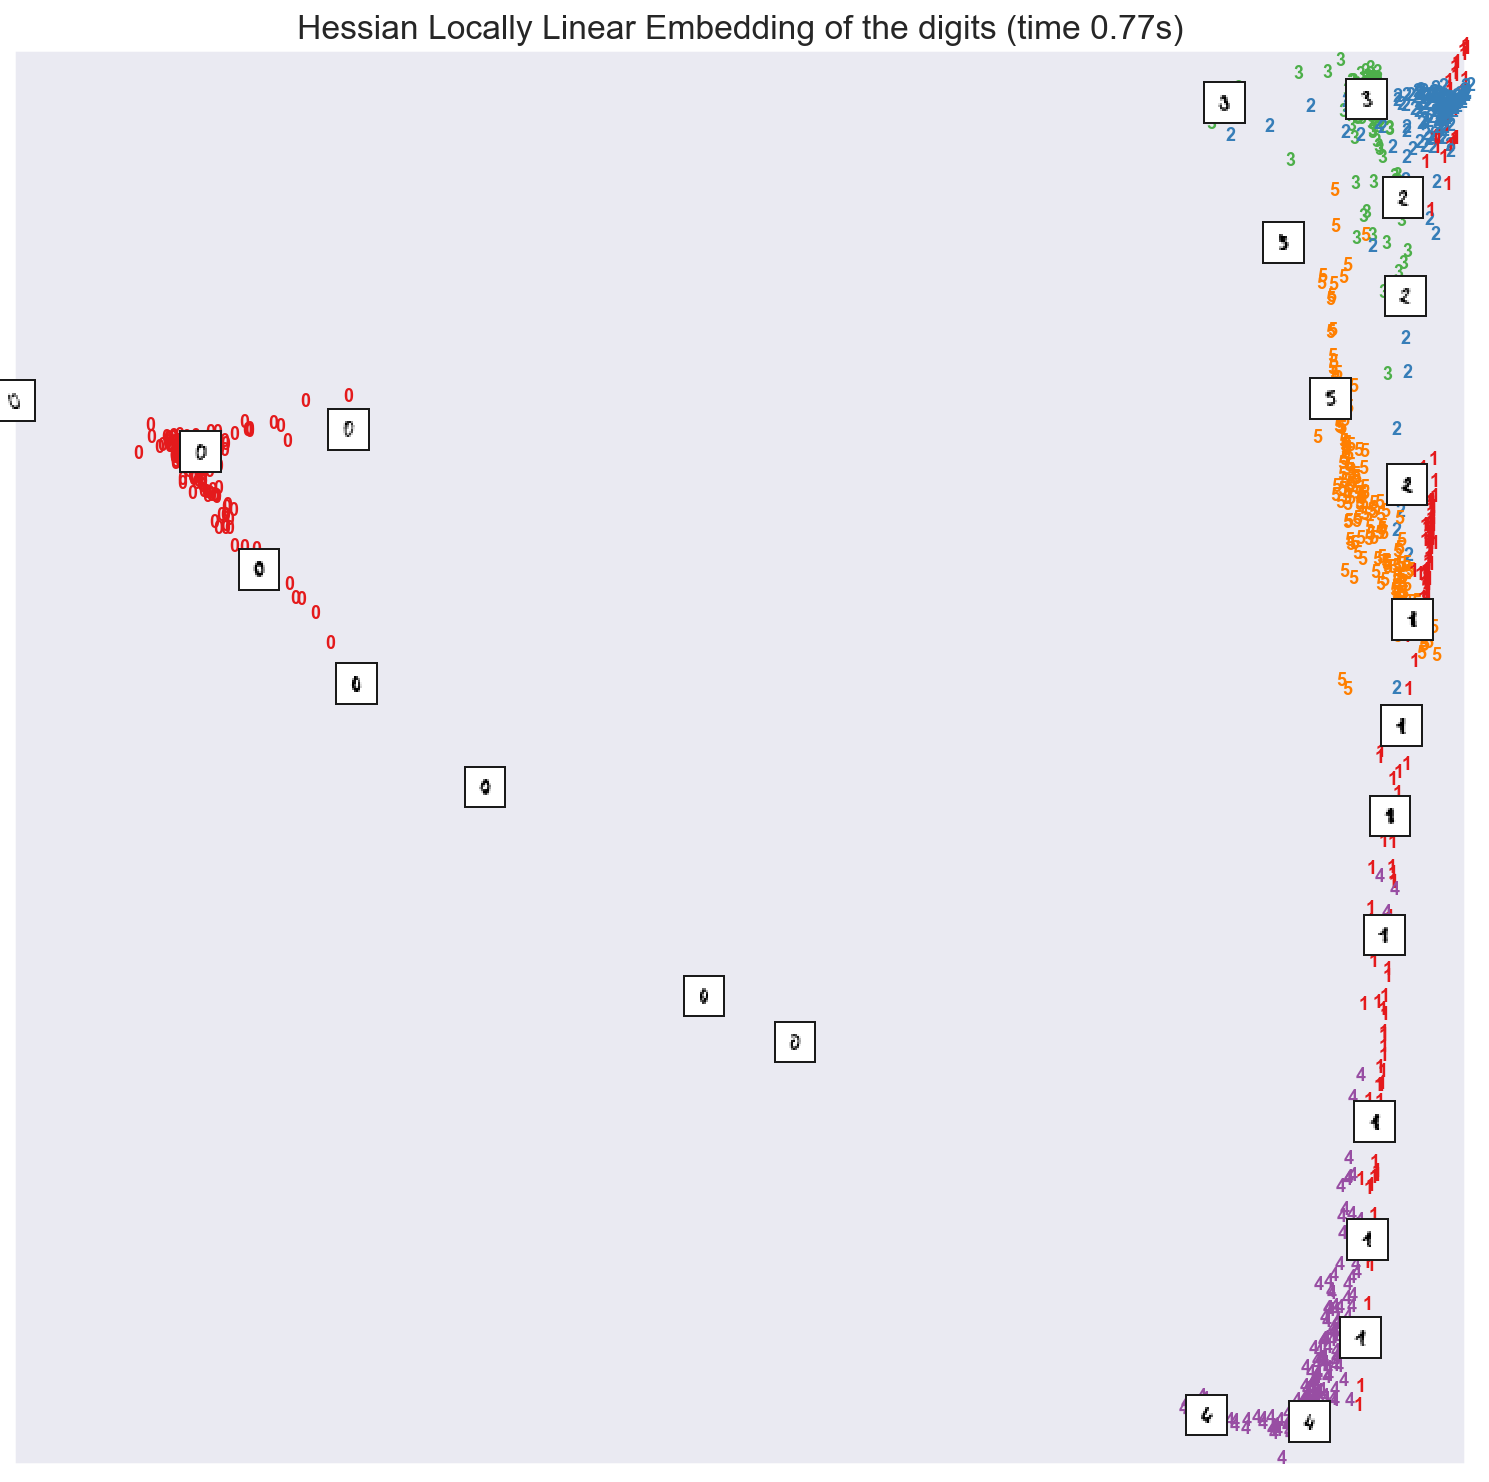

In [6]:
from sklearn.manifold import LocallyLinearEmbedding
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

## Spectral Embedding (with Laplacian eigenmaps)

Spectral Embedding, implemented with Laplacian eigenmaps builds a graph from neighborhood information of the data set. Each data point serves as a node on the graph and connectivity between nodes is governed by the proximity of neighboring points (using e.g. the k-nearest neighbor algorithm). The graph thus generated can be considered as a discrete approximation of the low-dimensional manifold in the high-dimensional space. Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low-dimensional space, preserving local distances. The eigenfunctions of the Laplace–Beltrami operator on the manifold serve as the embedding dimensions, since under mild conditions this operator has a countable spectrum that is a basis for square integrable functions on the manifold (compare to Fourier series on the unit circle manifold).

#### Complexity

The Spectral Embedding (Laplacian Eigenmaps) algorithm comprises three
stages:

1.  **Weighted Graph Construction**. Transform the raw input data into
    graph representation using affinity (adjacency) matrix
    representation.
2.  **Graph Laplacian Construction**. unnormalized Graph Laplacian is
    constructed as $L = D - A$ for and normalized one as
    $L = D^{-\frac{1}{2}} (D - A) D^{-\frac{1}{2}}$.
3.  **Partial Eigenvalue Decomposition**. Eigenvalue decomposition is
    done on graph Laplacian

The overall complexity of spectral embedding is
$O[D \log(k) N \log(N)] + O[D N k^3] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

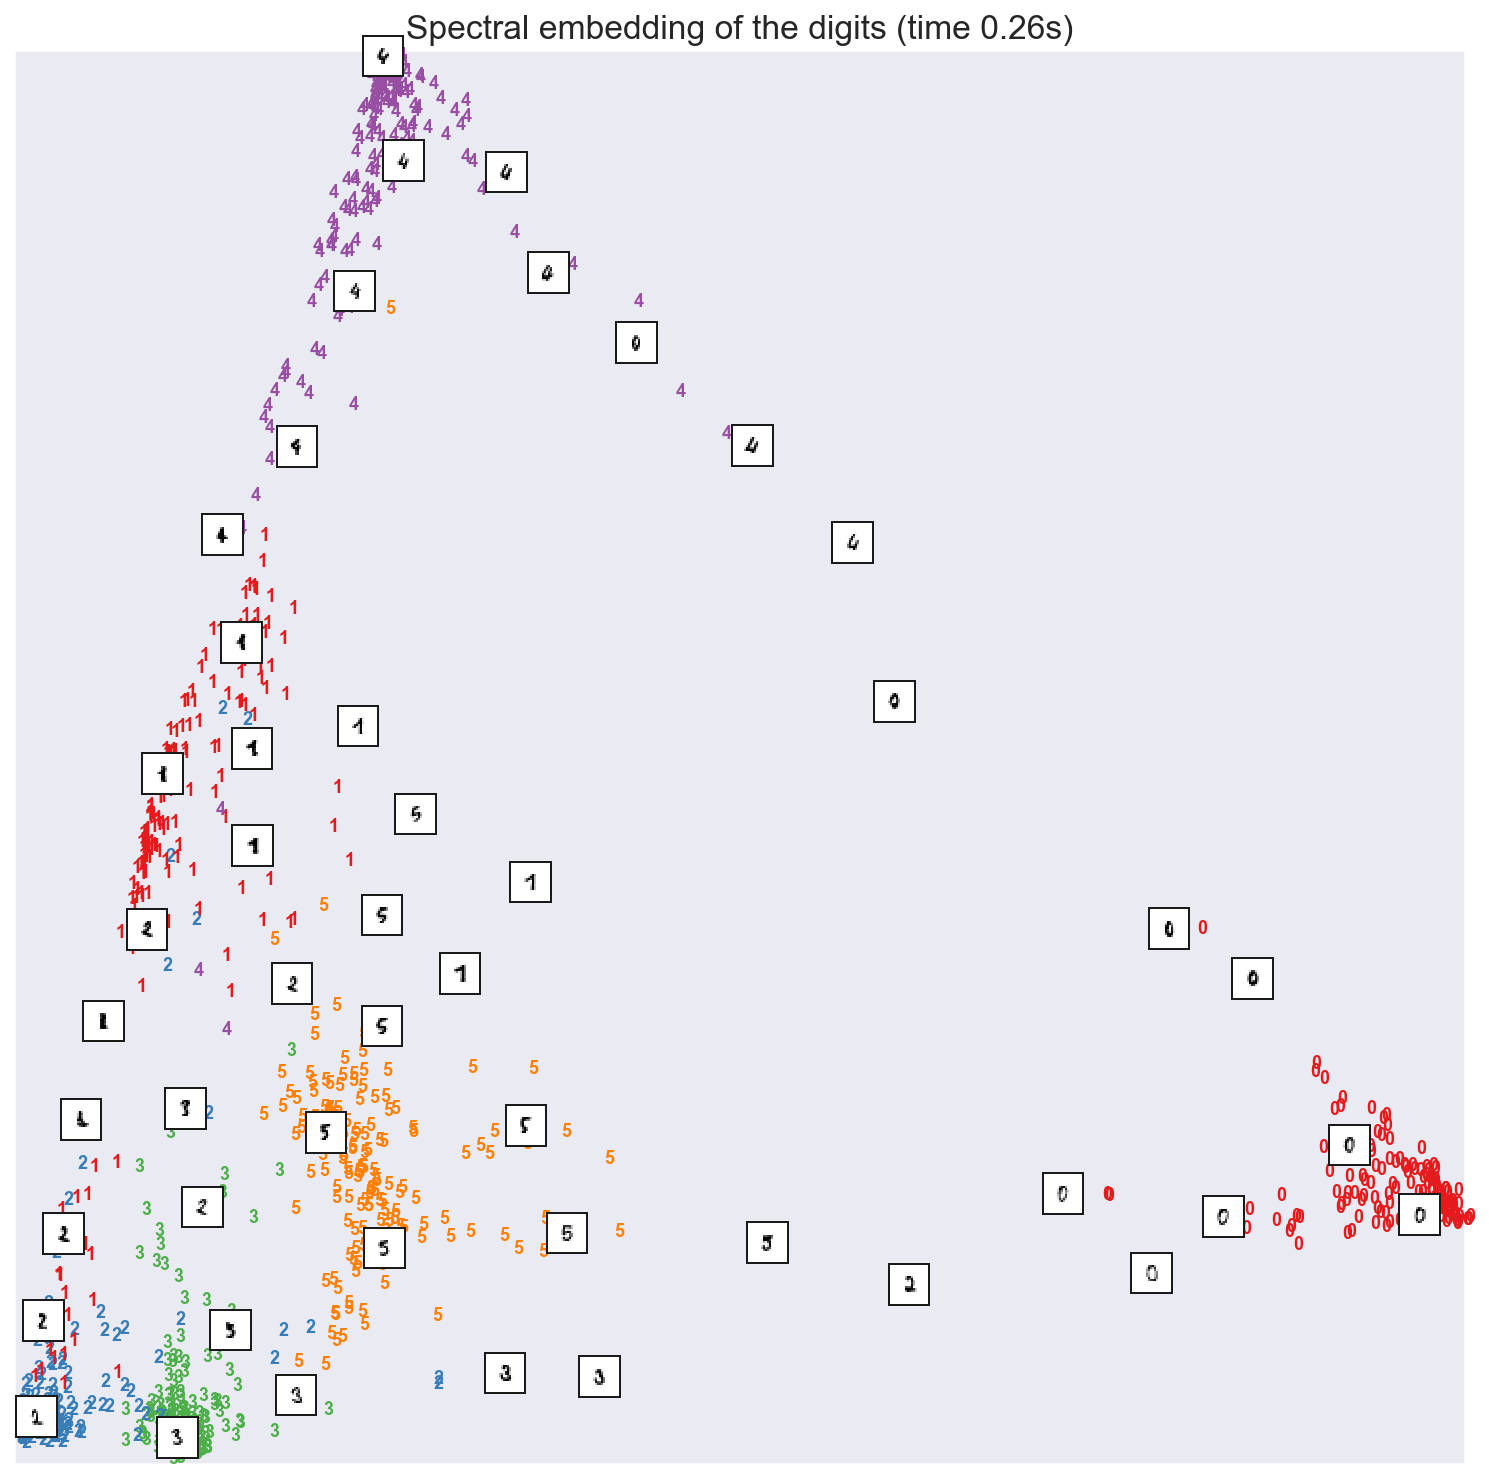

In [7]:
from sklearn.manifold import SpectralEmbedding
embedder = SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)
plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

## Local Tangent Space Alignment

LTSA is based on the intuition that when a manifold is correctly unfolded, all of the tangent hyperplanes to the manifold will become aligned. It begins by computing the k-nearest neighbors of every point. It computes the tangent space at every point by computing the d-first principal components in each local neighborhood. It then optimizes to find an embedding that aligns the tangent spaces.

LTSA can be performed `LocallyLinearEmbedding`, with the
keyword `method = 'ltsa'`.

#### Complexity

The LTSA algorithm comprises three stages:

1.  **Nearest Neighbors Search**. Same as standard LLE
2.  **Weight Matrix Construction**. Approximately
    $O[D N k^3] + O[k^2 d]$. The first term reflects a similar cost to
    that of standard LLE.
3.  **Partial Eigenvalue Decomposition**. Same as standard LLE

The overall complexity of standard LTSA is
$O[D \log(k) N \log(N)] + O[D N k^3] + O[k^2 d] + O[d N^2]$.

-   $N$ : number of training data points
-   $D$ : input dimension
-   $k$ : number of nearest neighbors
-   $d$ : output dimension

Reconstruction error: 0.212803


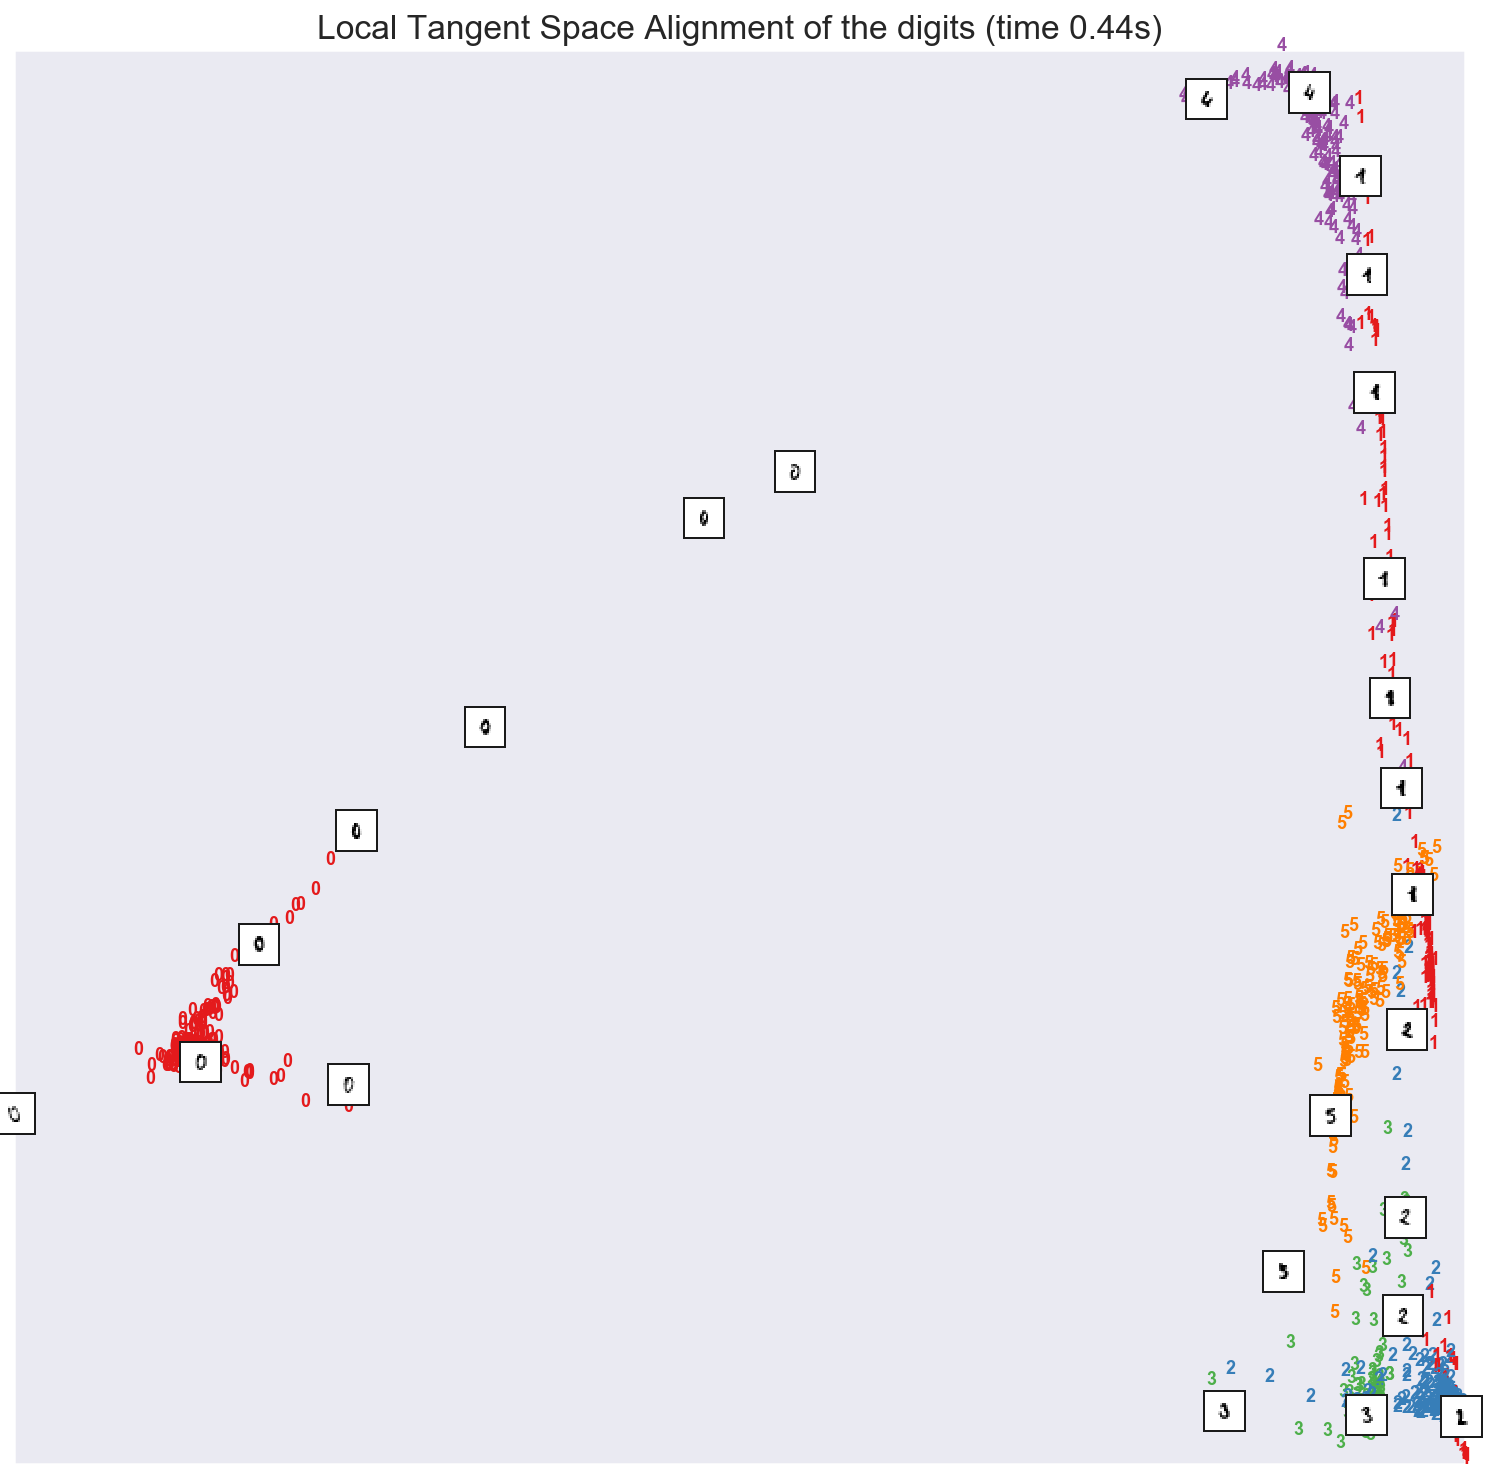

In [9]:
from sklearn.manifold import LocallyLinearEmbedding
clf = LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))

## Multi-dimensional Scaling (MDS) 

[Multidimensional
scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling)
(`MDS`) seeks a low-dimensional
representation of the data in which the distances respect well the
distances in the original high-dimensional space.

In general, `MDS` is a technique used
for analyzing similarity or dissimilarity data. It attempts to model
similarity or dissimilarity data as distances in a geometric spaces. The
data can be ratings of similarity between objects, interaction
frequencies of molecules, or trade indices between countries.

There exists two types of MDS algorithm: metric and non metric. In the
scikit-learn, the class `MDS` implements
both. In Metric MDS, the input similarity matrix arises from a metric
(and thus respects the triangular inequality), the distances between
output two points are then set to be as close as possible to the
similarity or dissimilarity data. In the non-metric version, the
algorithms will try to preserve the order of the distances, and hence
seek for a monotonic relationship between the distances in the embedded
space and the similarities/dissimilarities.

Let $S$ be the similarity matrix, and $X$ the coordinates of the $n$
input points. Disparities $\hat{d}_{ij}$ are transformation of the
similarities chosen in some optimal ways. The objective, called the
stress, is then defined by $\sum_{i < j} d_{ij}(X) - \hat{d}_{ij}(X)$

### Metric MDS

The simplest metric `MDS` model, called
*absolute MDS*, disparities are defined by $\hat{d}_{ij} = S_{ij}$. With
absolute MDS, the value $S_{ij}$ should then correspond exactly to the
distance between point $i$ and $j$ in the embedding point.

Most commonly, disparities are set to $\hat{d}_{ij} = b S_{ij}$.

### Nonmetric MDS

Non metric `MDS` focuses on the
ordination of the data. If $S_{ij} < S_{jk}$, then the embedding should
enforce $d_{ij} <
d_{jk}$. A simple algorithm to enforce that is to use a monotonic
regression of $d_{ij}$ on $S_{ij}$, yielding disparities $\hat{d}_{ij}$
in the same order as $S_{ij}$.

A trivial solution to this problem is to set all the points on the
origin. In order to avoid that, the disparities $\hat{d}_{ij}$ are
normalized.

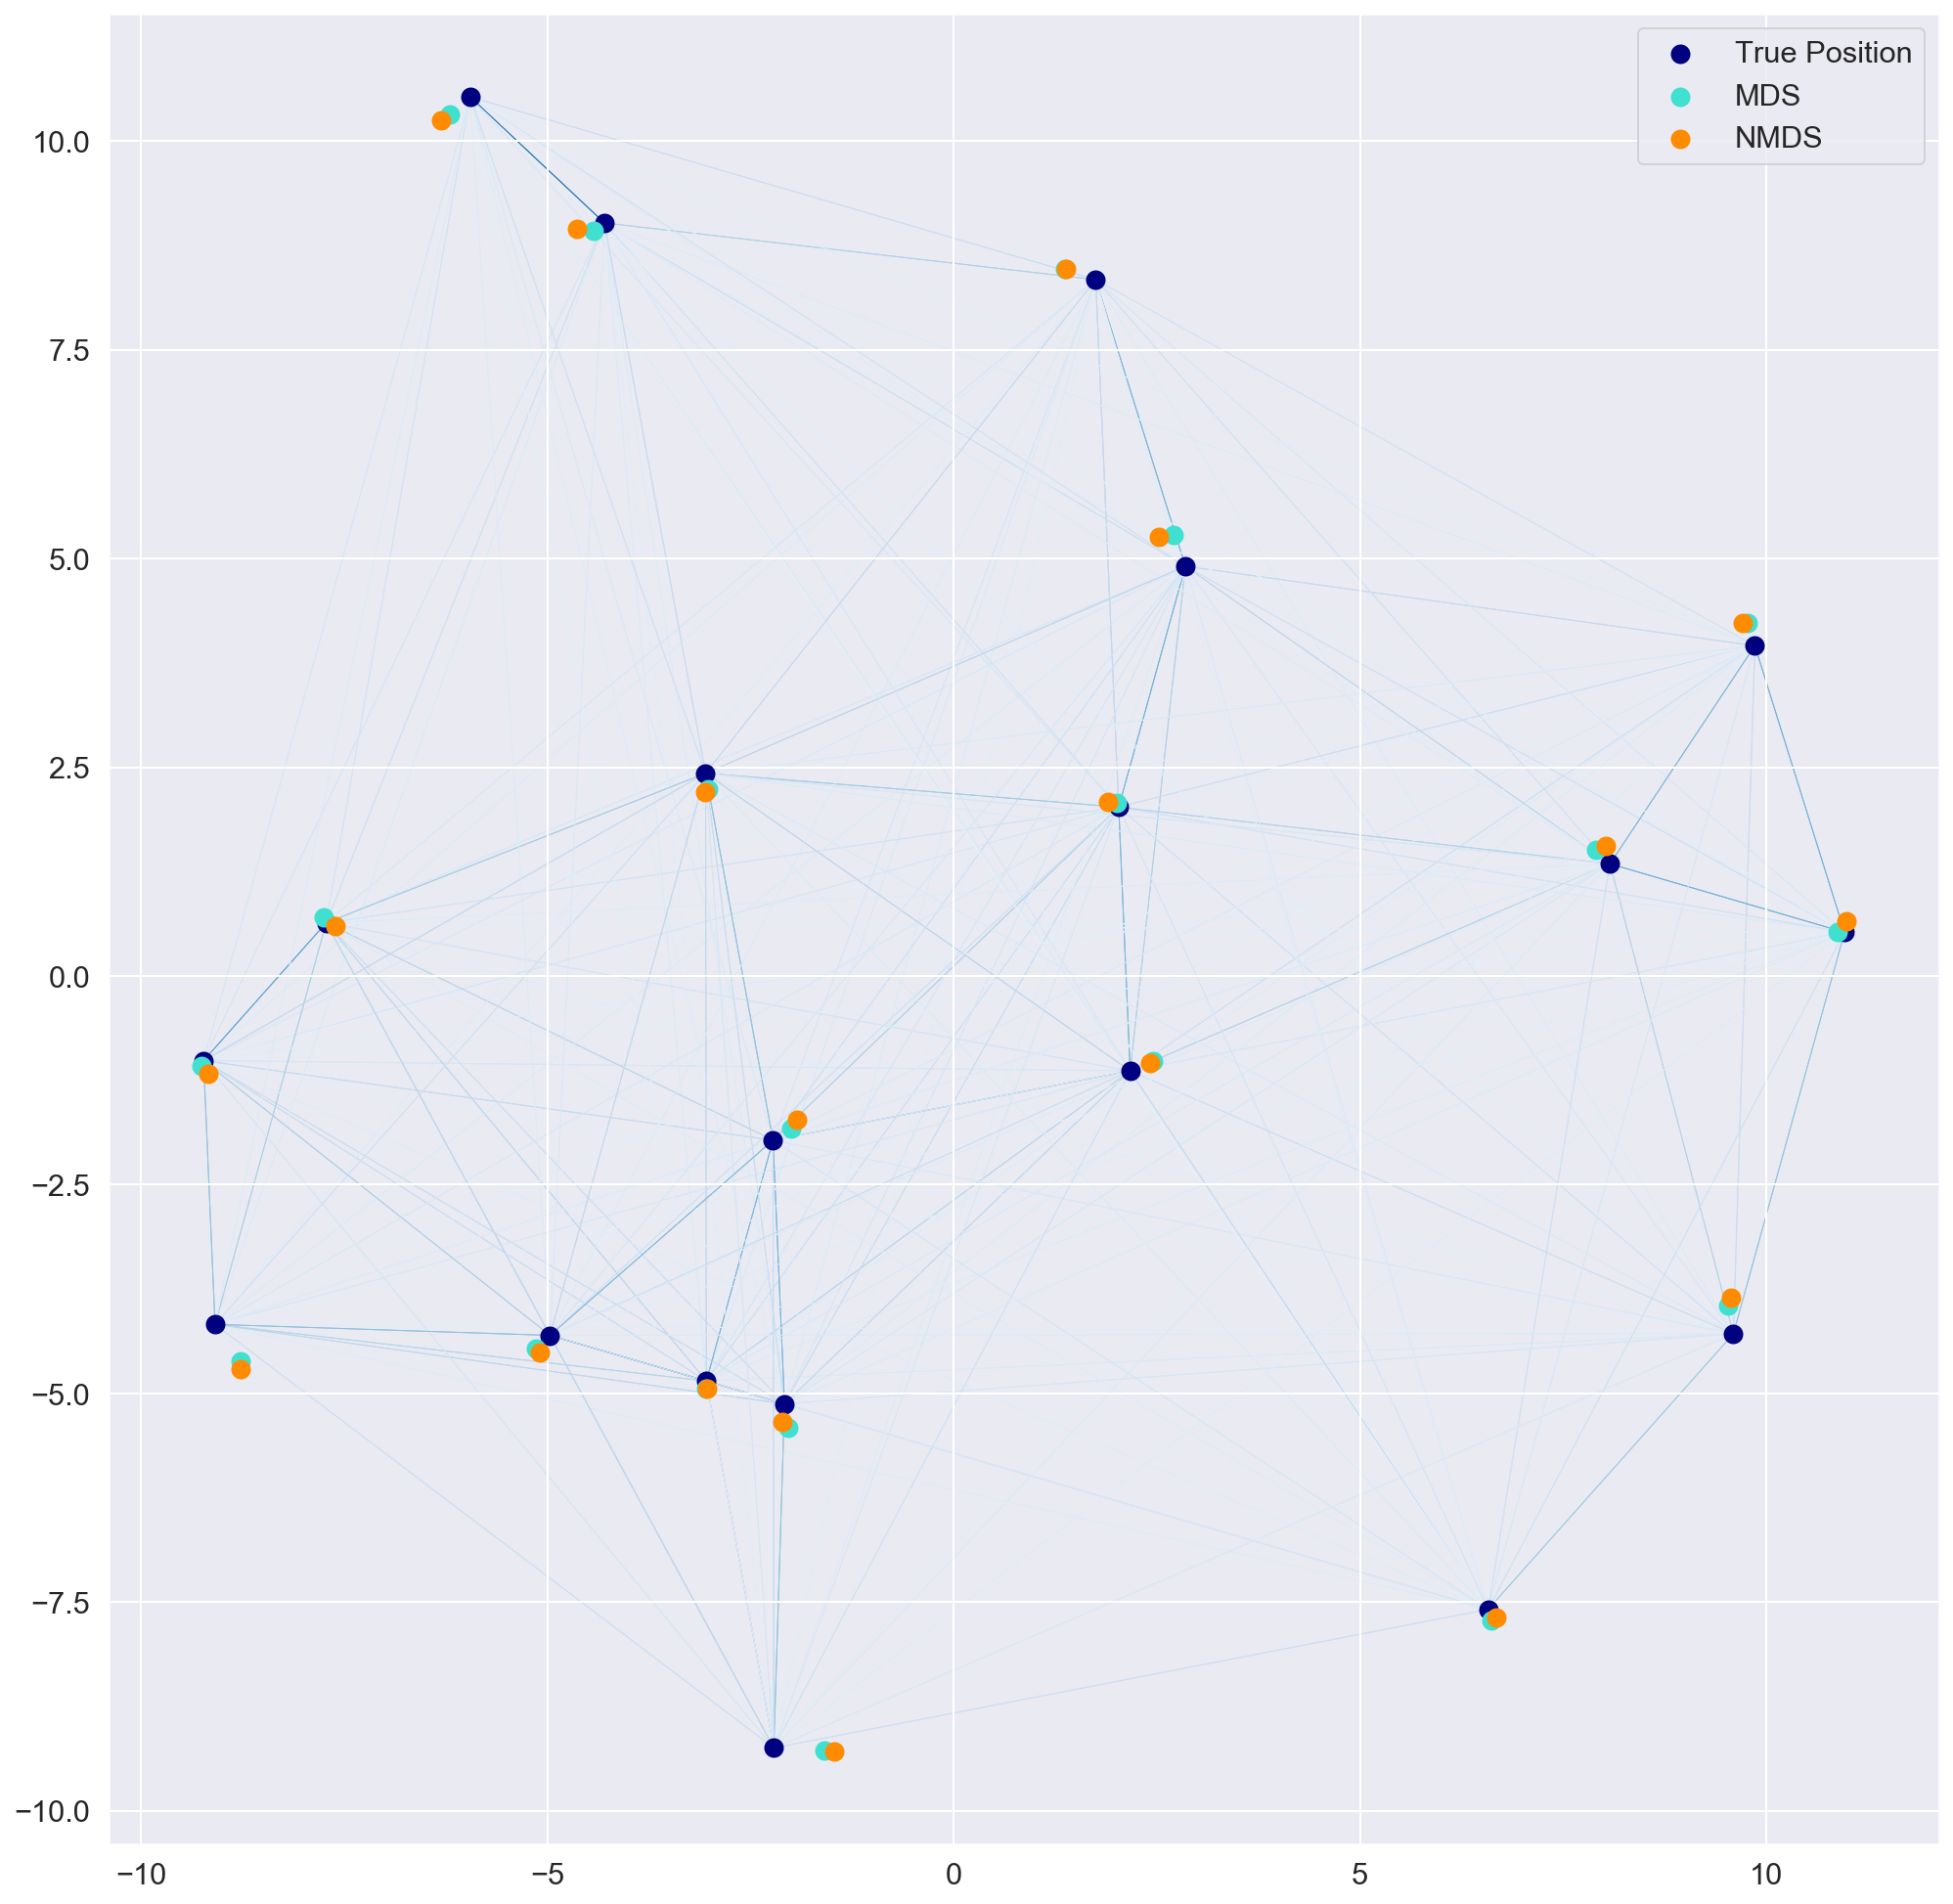

In [11]:
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(np.float)
X_true = X_true.reshape((n_samples, 2))
# Center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

fig = plt.figure(figsize=(13, 13))
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color='navy', s=s, lw=0,
            label='True Position')
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color='darkorange',
            s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

Stress: 170345032.213754 (The final value of the stress (sum of squared distance of the disparities and the distances for all constrained points).)


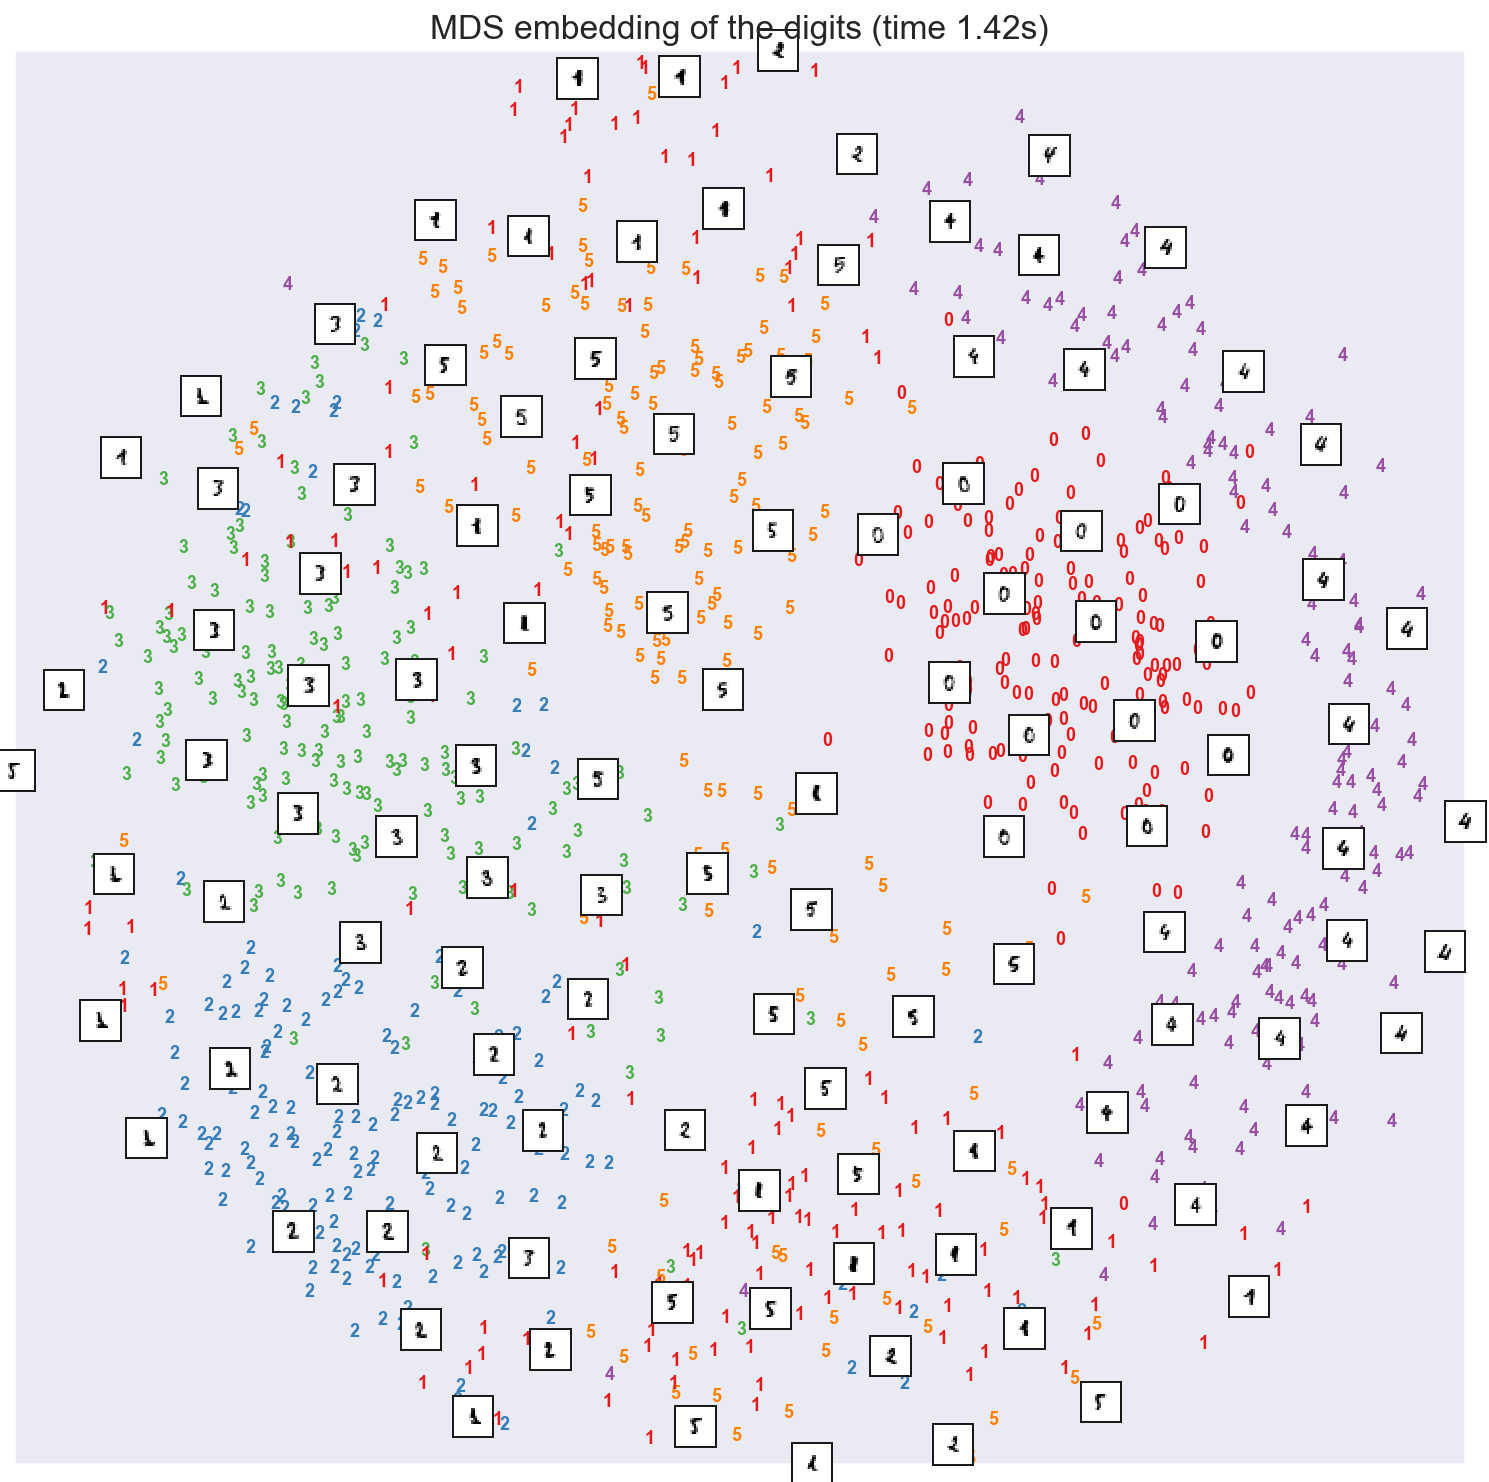

In [13]:
from sklearn.manifold import MDS
clf = MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Stress: %f (The final value of the stress (sum of squared distance of the disparities and the distances for all constrained points).)" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

## t-distributed stochastic neighbor embedding

t-distributed stochastic neighbor embedding (t-SNE) is widely used. It is one of a family of stochastic neighbor embedding methods. The algorithm computes the probability that pairs of datapoints in the high-dimensional space are related, and then chooses low-dimensional embeddings which produce a similar distribution.

The t-SNE algorithm comprises two main stages:
1. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked while dissimilar points have an extremely small probability of being picked.
2. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.

t-SNE (`TSNE`) converts affinities of
data points to probabilities. The affinities in the original space are
represented by Gaussian joint probabilities and the affinities in the
embedded space are represented by Student's t-distributions. This
allows t-SNE to be particularly sensitive to local structure and has a
few other advantages over existing techniques:

-   Revealing the structure at many scales on a single map
-   Revealing data that lie in multiple, different, manifolds or
    clusters
-   Reducing the tendency to crowd points together at the center

While Isomap, LLE and variants are best suited to unfold a single
continuous low dimensional manifold, t-SNE will focus on the local
structure of the data and will tend to extract clustered local groups of
samples. This ability to group
samples based on the local structure might be beneficial to visually
disentangle a dataset that comprises several manifolds at once as is the
case in the digits dataset.

The Kullback-Leibler (KL) divergence of the joint probabilities in the
original space and the embedded space will be minimized by gradient
descent. Note that the KL divergence is not convex, i.e. multiple
restarts with different initializations will end up in local minima of
the KL divergence. Hence, it is sometimes useful to try different seeds
and select the embedding with the lowest KL divergence.

The disadvantages to using t-SNE are roughly:

-   t-SNE is computationally expensive, and can take several hours on
    million-sample datasets where PCA will finish in seconds or minutes
-   The Barnes-Hut t-SNE method is limited to two or three dimensional
    embeddings.
-   The algorithm is stochastic and multiple restarts with different
    seeds can yield different embeddings. However, it is perfectly
    legitimate to pick the embedding with the least error.
-   Global structure is not explicitly preserved. This problem is
    mitigated by initializing points with PCA).



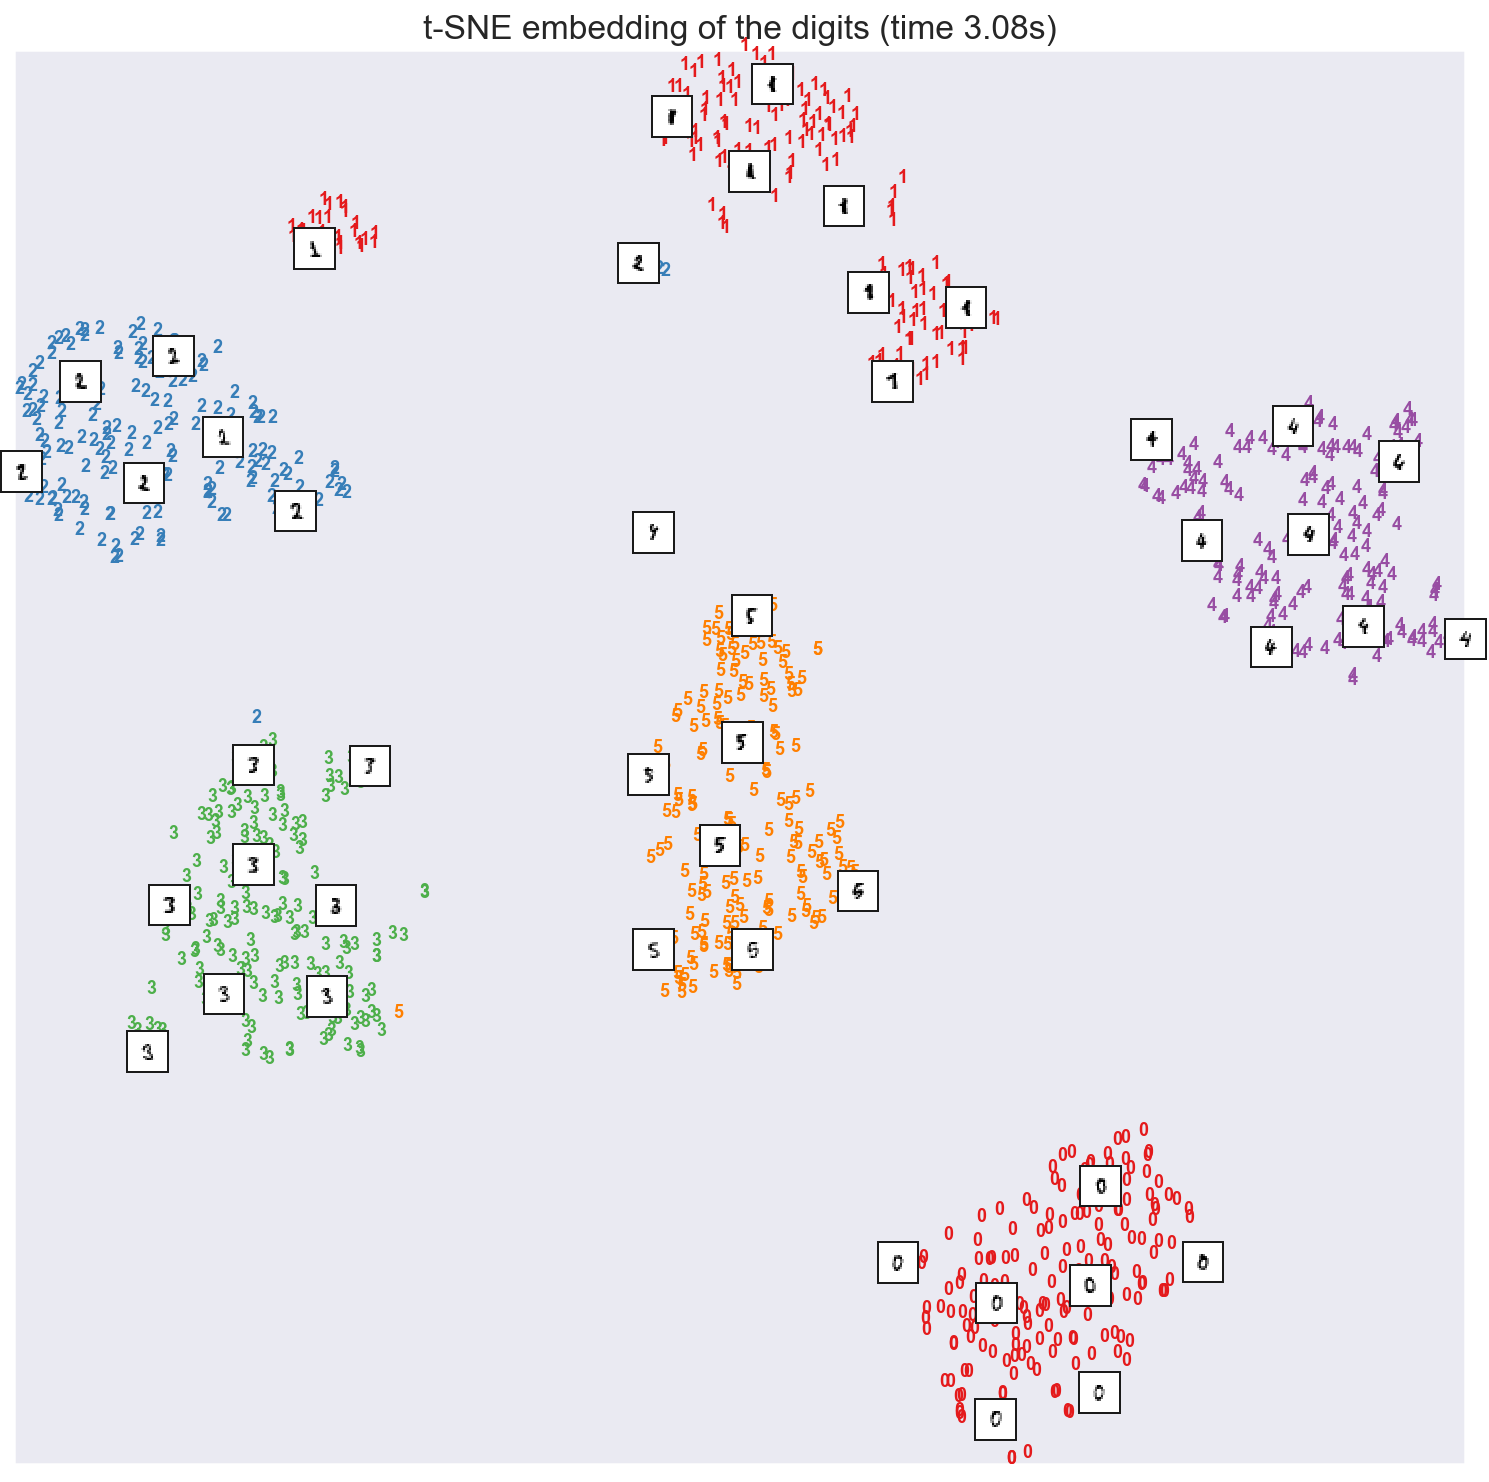

In [15]:
from sklearn.manifold import TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

#### Optimizing t-SNE

The main purpose of t-SNE is visualization of high-dimensional data.
Hence, it works best when the data will be embedded on two or three
dimensions.

Optimizing the KL divergence can be a little bit tricky sometimes. There
are five parameters that control the optimization of t-SNE and therefore
possibly the quality of the resulting embedding:

-   perplexity
-   early exaggeration factor
-   learning rate
-   maximum number of iterations
-   angle (not used in the exact method)

The perplexity is defined as $k=2^{(S)}$ where $S$ is the Shannon
entropy of the conditional probability distribution. The perplexity of a
$k$-sided die is $k$, so that $k$ is effectively the number of nearest
neighbors t-SNE considers when generating the conditional probabilities.
Larger perplexities lead to more nearest neighbors and less sensitive to
small structure. Conversely a lower perplexity considers a smaller
number of neighbors, and thus ignores more global information in favour
of the local neighborhood. As dataset sizes get larger more points will
be required to get a reasonable sample of the local neighborhood, and
hence larger perplexities may be required. Similarly noisier datasets
will require larger perplexity values to encompass enough local
neighbors to see beyond the background noise.

The maximum number of iterations is usually high enough and does not
need any tuning. The optimization consists of two phases: the early
exaggeration phase and the final optimization. During early exaggeration
the joint probabilities in the original space will be artificially
increased by multiplication with a given factor. Larger factors result
in larger gaps between natural clusters in the data. If the factor is
too high, the KL divergence could increase during this phase. Usually it
does not have to be tuned. A critical parameter is the learning rate. If
it is too low gradient descent will get stuck in a bad local minimum. If
it is too high the KL divergence will increase during optimization. The
last parameter, angle, is a tradeoff between performance and accuracy.
Larger angles imply that we can approximate larger regions by a single
point, leading to better speed but less accurate results.

[\"How to Use t-SNE
Effectively\"](https://distill.pub/2016/misread-tsne/) provides a good
discussion of the effects of the various parameters, as well as
interactive plots to explore the effects of different parameters.

#### Barnes-Hut t-SNE

The Barnes-Hut t-SNE that has been implemented here is usually much
slower than other manifold learning algorithms. The optimization is
quite difficult and the computation of the gradient is $O[d N log(N)]$,
where $d$ is the number of output dimensions and $N$ is the number of
samples. The Barnes-Hut method improves on the exact method where t-SNE
complexity is $O[d N^2]$, but has several other notable differences:

-   The Barnes-Hut implementation only works when the target
    dimensionality is 3 or less. The 2D case is typical when building
    visualizations.
-   Barnes-Hut only works with dense input data. Sparse data matrices
    can only be embedded with the exact method or can be approximated by
    a dense low rank projection for instance using
    `sklearn.decomposition.TruncatedSVD`
-   Barnes-Hut is an approximation of the exact method. The
    approximation is parameterized with the angle parameter, therefore
    the angle parameter is unused when method=\"exact\"
-   Barnes-Hut is significantly more scalable. Barnes-Hut can be used to
    embed hundred of thousands of data points while the exact method can
    handle thousands of samples before becoming computationally
    intractable

For visualization purpose (which is the main use case of t-SNE), using
the Barnes-Hut method is strongly recommended. The exact t-SNE method is
useful for checking the theoretically properties of the embedding
possibly in higher dimensional space but limit to small datasets due to
computational constraints.

Also note that the digits labels roughly match the natural grouping
found by t-SNE while the linear 2D projection of the PCA model yields a
representation where label regions largely overlap. This is a strong
clue that this data can be well separated by non linear methods that
focus on the local structure (e.g. an SVM with a Gaussian RBF kernel).
However, failing to visualize well separated homogeneously labeled
groups with t-SNE in 2D does not necessarily imply that the data cannot
be correctly classified by a supervised model. It might be the case that
2 dimensions are not low enough to accurately represents the internal
structure of the data.


## Tips on practical use


-   Make sure the same scale is used over all features. Because manifold
    learning methods are based on a nearest-neighbor search, the
    algorithm may perform poorly otherwise. See
    `StandardScaler` for convenient ways of scaling heterogeneous data.
-   The reconstruction error computed by each routine can be used to
    choose the optimal output dimension. For a $d$-dimensional manifold
    embedded in a $D$-dimensional parameter space, the reconstruction
    error will decrease as `n_components` is increased until
    `n_components == d`.
-   Note that noisy data can \"short-circuit\" the manifold, in essence
    acting as a bridge between parts of the manifold that would
    otherwise be well-separated. Manifold learning on noisy and/or
    incomplete data is an active area of research.
-   Certain input configurations can lead to singular weight matrices,
    for example when more than two points in the dataset are identical,
    or when the data is split into disjointed groups. In this case,
    `solver='arpack'` will fail to find the null space. The easiest way
    to address this is to use `solver='dense'` which will work on a
    singular matrix, though it may be very slow depending on the number
    of input points. Alternatively, one can attempt to understand the
    source of the singularity: if it is due to disjoint sets, increasing
    `n_neighbors` may help. If it is due to identical points in the
    dataset, removing these points may help.